# Imports

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os, json
import xarray as xr
from datetime import datetime
from sklearn.neighbors import KernelDensity

# Basic functions

In [2]:
def read_timestamp_series(s):
    output_time = []
    fmt = '%H:%M:%S.%f'
    if s.dtype != np.float64:
        for current_time in s:
            str_time = str(current_time).strip()
            try:
                t = datetime.strptime(str_time, fmt)
            except ValueError as v:
                ulr = len(v.args[0].partition('unconverted data remains: ')[2])
                if ulr:
                    str_time = str_time[:-ulr]
            try:
                output_time.append((datetime.strptime(str_time, '%H:%M:%S.%f') - datetime.strptime('00:00:00.000000', '%H:%M:%S.%f')).total_seconds())
            except ValueError:
                output_time.append(np.nan)
        output_time = np.array(output_time)
    else:
        output_time = s.values
    return output_time

def read_timestamp_file(path):
    # read data and set up format
    s = pd.read_csv(path, encoding='utf-8', engine='c', header=None).squeeze()
    if s[0] == 0:
        s = s[1:]
    camT = read_timestamp_series(s)
    return camT

def calc_PSTH(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    calcualtes for a single cell at a time

    bandwidth (msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """

    bandwidth = bandwidth / 1000
    resample_size = resample_size / 1000
    win = win / 1000
    edgedrop = edgedrop / 1000
    edgedrop_ind = int(edgedrop / resample_size)

    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # Timestamps of spikes (`sps`) relative to `eventT`
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        # Only keep spikes in this window
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] 
        sps.extend(sp)
    sps = np.array(sps)

    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:, np.newaxis])
    density = kernel.score_samples(bins[:, np.newaxis])

    # Multiply by the # spikes to get spike count per point. Divide
    # by # events for rate/event.
    psth = np.exp(density) * (np.size(sps ) / np.size(eventT))

    # Drop padding at start & end to eliminate edge effects.
    psth = psth[edgedrop_ind:-edgedrop_ind]

    return psth

# Paths

In [3]:
recpath = '/home/niell_lab/Data/freely_moving_ephys/new_hf_stim/worldcam_playback/041422/J559RT/hf4_worldcam'

# Frame times

In [5]:
imu_path = os.path.join(recpath, '041422_J599RT_control_Rig2_hf4_worldcam_IMU.bin')

In [6]:
dtypes = np.dtype([
    ("acc_x",np.uint16),
    ("acc_y",np.uint16),
    ("acc_z",np.uint16),
    ("none1",np.uint16), # 3
    ("gyro_x",np.uint16),
    ("gyro_y",np.uint16),
    ("gyro_z",np.uint16),
    ("none2",np.uint16) # 7
])
imu = pd.DataFrame(np.fromfile(imu_path, dtypes, -1, '')).to_numpy()

In [7]:
path = os.path.join(recpath, '041422_J599RT_control_Rig2_hf4_worldcam_Ephys_BonsaiBoardTS.csv')
imuT_ = read_timestamp_file(path)

In [8]:
t0 = imuT_[0]
num_samp = np.size(imu,0)
samp_freq = 30000
imuT = np.array(t0 + np.linspace(0, num_samp-1, num_samp) / samp_freq)

In [9]:
use_onsets = imu[:,3]-np.median(imu)
use_diff = np.diff(use_onsets)
use_show = use_diff/np.max(use_diff)
use_show[use_show < 0] = 0
frame_onset_frames = np.argwhere(use_show > 0.5).flatten()
frame_onset_times = imuT[frame_onset_frames] - t0

In [11]:
stimstart = imu[:,7]-np.median(imu)
stimstart_diff = np.diff(stimstart)
stimstart_diff = stimstart_diff/np.max(stimstart_diff)
stimstart_diff[stimstart_diff<0] = 0
stim_restart_frames = np.argwhere(stimstart_diff > 0.5).flatten()
stim_restart_times = imuT[stim_restart_frames] - t0

# Timestamp that stimulus frames were shown at

In [12]:
# shape will be [presentation timestamp, stim frame number]
stim_labels = np.zeros([len(frame_onset_times)])*np.nan

stim_count = 0

# iterater through stimulus frame onsets
for f, t in enumerate(frame_onset_times):
    
    # how many times has the stimulus video been repeated so far?
    stim_count = np.size(stim_restart_times[stim_restart_times<=t])
    
    # skip this if the stimulus video hasn't shown the "first" frame yet
    # i.e. if it started partway through displaying the 1 min stimulus
    if stim_count == 0:
        continue
    
    # what is the timstamp of the first frame of this stimulus cycle?
    cycle_start = stim_restart_times[stim_count-1]
    
    # how many frames have been shown since this stimulus cycle started?
    # max value should be 3600 frames (60fps for 60sec)
    elapsed_frames = np.sum((frame_onset_times<=t) * (frame_onset_times>=cycle_start))
    
    stim_labels[f] = elapsed_frames
    

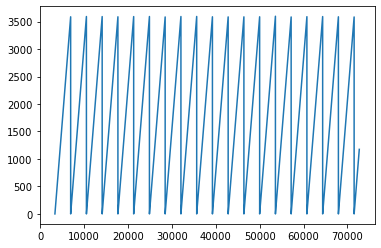

In [13]:
plt.plot(stim_labels)

# Ephys during playback

In [14]:
ephys_path = os.path.join(recpath,'041422_J599RT_control_Rig2_hf4_worldcam_ephys_merge.json')
ephys_data = pd.read_json(ephys_path)

In [15]:
# sort by ch
ephys_data = ephys_data.sort_values(by='ch', axis=0, ascending=True)
ephys_data = ephys_data.reset_index()
ephys_data = ephys_data.drop('index', axis=1)

In [16]:
# good cells
ephys = ephys_data.loc[ephys_data['group']=='good']

In [17]:
# timing correction
offset = 0.1
drift = -0.000114

ephys['spikeT_'] = ephys['spikeT'].copy()
for ind, row in ephys.iterrows():
    sps = np.array(row['spikeT_'].copy()).astype(float)
    ephys.at[ind,'spikeT'] = sps - (offset + sps * drift)

/tmp/ipykernel_1176621/2649321378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ephys['spikeT_'] = ephys['spikeT'].copy()


# Saccade times in stimulus

In [18]:
with open('/home/niell_lab/Desktop/worldcam_playback_saccframes.json', 'r') as fp:
    saccFr = json.load(fp)

# Responses during playback

In [23]:
# all the times in the recording when a gaze shift was shown on the monitor
use_fr = []
for f in (saccFr['gazeL']+saccFr['gazeR']):
    use_fr.extend(list(np.where(stim_labels==f)[0]))
use_fr = sorted(use_fr)

eventT = np.array([frame_onset_times[f] for f in use_fr])

all_psth = np.zeros([len(ephys.index.values), 2001])

for i, ind in tqdm(enumerate(ephys.index.values)):
    
    sps = np.array(ephys.loc[ind,'spikeT'].copy()).astype(float)
    psth = calc_PSTH(sps, eventT)
    
    all_psth[i,:] = psth

80it [01:43,  1.30s/it]


# some plots

In [ ]:
# plot PSTHs
bins = np.arange(-1000,1001,1)

fig, axs = plt.subplots(10,8, dpi=300, figsize=(15,15))

for i, ind in enumerate(ephys.index.values):
    psth = all_psth[i,:]
    
    row = int(np.floor(i/8))
    col = int(i%8)
    
    axs[row,col].plot(bins, psth)
    axs[row,col].vlines(0, 0, np.max(psth)*1.1, color='k', linestyle='dashed')
    axs[row,col].set_ylim([0, np.max(psth)*1.1])
    axs[row,col].set_title(ind)
    axs[row,col].set_xticklabels([])
    axs[row,col].set_xlim([-500,500])

fig.tight_layout()

In [ ]:
# plot raster
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=300)
sps = np.array(ephys.loc[11, 'spikeT_'].copy())
for i, t in enumerate(stim_restart_times):
    sps_i = sps[(sps>t) * (sps<(t+3))]
    sps_i = sps_i - t
    ax.plot(sps_i, np.ones(len(sps_i))*i, '|')
    ax.vlines((eventT-t)[(eventT>t) * (eventT<(t+3))], 0, 20, 'k')